<a href="https://colab.research.google.com/github/BossBosssmile/AmpliGraph/blob/main/AmpliGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount google drive

In [ ]:
!pip install neo4j 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!ls /content/gdrive/MyDrive/

In [ ]:
PATH = '/content/gdrive/MyDrive/'

# Setup and comfig

In [ ]:
!pip install ampligraph

     |████████████████████████████████| 168 kB 9.3 MB/s 
     |████████████████████████████████| 407 kB 40.3 MB/s 
     |████████████████████████████████| 2.7 MB 26.6 MB/s 
     |████████████████████████████████| 6.4 MB 28.6 MB/s 
     |████████████████████████████████| 64 kB 2.5 MB/s 
     |████████████████████████████████| 120 kB 51.0 MB/s 
     |████████████████████████████████| 561 kB 25.7 MB/s 
     |████████████████████████████████| 42 kB 877 kB/s 
     |████████████████████████████████| 69 kB 7.4 MB/s 
     |████████████████████████████████| 41 kB 561 kB/s 
     |████████████████████████████████| 100 kB 8.9 MB/s 
     |████████████████████████████████| 84 kB 3.3 MB/s 
     |████████████████████████████████| 90 kB 9.1 MB/s 
     |████████████████████████████████| 121 kB 59.8 MB/s 
  Created wheel for commonmark: filename=CommonMark-0.5.4-py3-none-any.whl size=30766 sha256=57df75bf6cad6d8f016a2a9cf3864a550411bf8259678a55761312040e46d18e
  Stored in directory: /root/.cache/pip/whee

In [ ]:
class Neo4jConnection:
    
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, parameters=None, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            response = list(session.run(query, parameters))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response

In [ ]:
host = "bolt://3.239.105.70:7687"
user = "neo4j"
password = "shafts-jug-gum"

# connect to neo4j
conn = Neo4jConnection(uri=host, user=user, pwd=password)

In [ ]:
query = """
MATCH (s)-[r]->(t)
RETURN properties(s).identify_name as head, properties(t).identify_name AS tail, type(r) as relation
"""

a = conn.query(query); a

In [ ]:
!pip uninstall tensorflow
!pip install tensorflow==1.15.2

In [ ]:
import numpy as np
import pandas as pd
import ampligraph
import matplotlib.pyplot as plt
import seaborn as sns

from neo4j import GraphDatabase
from ampligraph.evaluation import train_test_split_no_unseen
from ampligraph.datasets import load_from_csv
from ampligraph.latent_features import ComplEx
from ampligraph.evaluation import evaluate_performance
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score
from ampligraph.latent_features import save_model, restore_model
import tensorflow as tf

# EDA

## Load dataset

In [ ]:
X = np.array([i.values() for i in a])
X

array([['BANGKOK AND SURROUNDING', 'THAILAND', 'part_of'],
       ['INCEPTION', 'ACTION', 'type_of'],
       ['INCEPTION', 'SCIENCE FICTION', 'type_of'],
       ...,
       ['LIVERPOOL', 'CITY', 'is_a'],
       ['PARIS', 'FRANCE', 'part_of'],
       ['PARIS', 'CITY', 'is_a']], dtype='<U42')

In [ ]:
X.shape

(1264, 3)

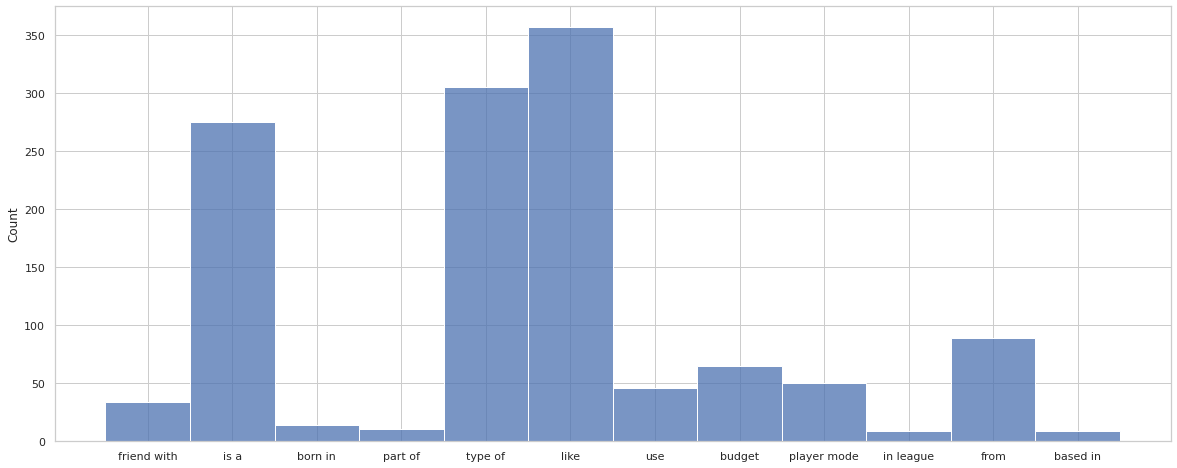

In [ ]:
sns.set_theme(rc = {'figure.figsize':(20,8)},
              style="whitegrid")
sns.histplot(X[:,1])

# Defining Train and Test datasets


In [ ]:
num_test = int(len(X) * 0.2)

data = {}
data['train'], data['test'] = train_test_split_no_unseen(X, test_size=num_test, seed=0, allow_duplication=False) 

print('Train set size: ', data['train'].shape)
print('Test set size: ', data['test'].shape)

Train set size:  (1012, 3)
Test set size:  (252, 3)


# Training a model

In [ ]:
model = ComplEx(batches_count=100, 
                seed=0, 
                epochs=200, 
                k=150, 
                eta=5,
                optimizer='adam', 
                optimizer_params={'lr':1e-3},
                loss='multiclass_nll', 
                regularizer='LP', 
                regularizer_params={'p':3, 'lambda':1e-5}, 
                verbose=True)

# Filtering negatives

In [ ]:
positives_filter = X

In [ ]:
tf.logging.set_verbosity(tf.logging.ERROR)

model.fit(data['train'], early_stopping = False)

Average ComplEx Loss:   0.057000: 100%|██████████| 200/200 [01:05<00:00,  3.07epoch/s]


# Saving and restoring a model

In [ ]:
save_model(model, './best_model.pkl')

In [ ]:
del model

In [ ]:
model = restore_model('./best_model.pkl')

In [ ]:
if model.is_fitted:
    print('The model is fit!')
else:
    print('The model is not fit! Did you skip a step?')

The model is fit!


# Evaluating a model

In [ ]:
ranks = evaluate_performance(data['test'], 
                             model=model, 
                             filter_triples=positives_filter,   # Corruption strategy filter defined above 
                             use_default_protocol=True, # corrupt subj and obj separately while evaluating
                             verbose=True)

WARNING - DeprecationWarning: use_default_protocol will be removed in future. Please use corrupt_side argument instead.


100%|██████████| 252/252 [00:00<00:00, 258.94it/s]


In [ ]:
mrr = mrr_score(ranks)
print("MRR: %.2f" % (mrr))

hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

MRR: 0.33
Hits@10: 0.55
Hits@3: 0.37
Hits@1: 0.22


## Predicting New Links

In [ ]:
X_food = np.array([
    ['P001', 'like', 'COPPER'],
    ['P001', 'like', 'MOMO PARADISE'],
    ['P001', 'like', 'TEENOI'],
    ['P001', 'like', 'KOSIRAE'],
    ['P002', 'like', 'TENJO'],
    ['P002', 'like', 'KOSIRAE'],
    ['P002', 'like', 'TOKPOKI'],
    ['P002', 'like', 'BAR B Q PLAZA'],
    ['P003', 'like', 'SHABU'],
    ['P003', 'like', 'GRILLED PORK'],
    ['P003', 'like', 'RODDEEDED'],
    ['P003', 'like', 'BURNT SEA'],
    ['P004', 'like', 'YANGNOEY'],
    ['P004', 'like', 'TENJO'],
    ['P004', 'like', 'KOSIRAE'],
    ['P004', 'like', 'YANGNOEY'],
    
])

In [ ]:
food_filter = np.array(list({tuple(i) for i in np.vstack((positives_filter, X_food))}))

ranks_unseen = evaluate_performance(
    X_food, 
    model=model, 
    filter_triples=food_filter,   # Corruption strategy filter defined above 
    corrupt_side = 's+o',
    use_default_protocol=False, # corrupt subj and obj separately while evaluating
    verbose=True
)

scores = model.predict(X_food)

100%|██████████| 16/16 [00:00<00:00, 134.48it/s]


In [ ]:
from scipy.special import expit
probs = expit(scores)

pd.DataFrame(list(zip([' '.join(x) for x in X_food], 
                      ranks_unseen, 
                      np.squeeze(scores),
                      np.squeeze(probs))), 
             columns=['statement', 'rank', 'score', 'prob']).sort_values("score")

,statement,rank,score,prob
6,P002 like TOKPOKI,469,-0.532485,0.369938
10,P003 like RODDEEDED,423,-0.527439,0.371114
0,P001 like COPPER,178,0.751685,0.679546
2,P001 like TEENOI,105,1.772106,0.854719
13,P004 like TENJO,91,2.105206,0.891408
4,P002 like TENJO,101,2.785303,0.941876
11,P003 like BURNT SEA,64,3.655827,0.974811
8,P003 like SHABU,55,4.092797,0.983582
1,P001 like MOMO PARADISE,8,4.590352,0.989953
3,P001 like KOSIRAE,12,4.995424,0.993277


In [ ]:
X_game = np.array([
    ['P001', 'like', 'ROV'],
    ['P001', 'like', 'WARCRAFT'],
    ['P001', 'like', 'MAPLE STORY'],
    ['P001', 'like', 'ALIEN SHOOTER'],
    ['P002', 'like', 'PUBG'],
    ['P002', 'like', 'DOTA'],
    ['P002', 'like', 'UNO ONLINE'],
    ['P002', 'like', 'BATTLEFIELD'],
    ['P003', 'like', 'WALKR'],
    ['P003', 'like', 'LOL'],
    ['P003', 'like', 'CALL OF CTHULU'],
    ['P003', 'like', 'PANGYA'],
    ['P004', 'like', 'CIVILIZATION'],
    ['P004', 'like', 'FIFA'],
    ['P004', 'like', 'GENSHIN IMPACT'],
    ['P004', 'like', 'CITIES SKYLINE'],
        
])

In [ ]:
game_filter = np.array(list({tuple(i) for i in np.vstack((positives_filter, X_game))}))

ranks_unseen = evaluate_performance(
    X_game, 
    model=model, 
    filter_triples=food_filter,   # Corruption strategy filter defined above 
    corrupt_side = 's+o',
    use_default_protocol=False, # corrupt subj and obj separately while evaluating
    verbose=True
)

scores = model.predict(X_game)

100%|██████████| 16/16 [00:00<00:00, 121.86it/s]


In [ ]:
from scipy.special import expit
probs = expit(scores)

pd.DataFrame(list(zip([' '.join(x) for x in X_game], 
                      ranks_unseen, 
                      np.squeeze(scores),
                      np.squeeze(probs))), 
             columns=['statement', 'rank', 'score', 'prob']).sort_values("score")

,statement,rank,score,prob
7,P002 like BATTLEFIELD,663,-2.743099,0.060478
6,P002 like UNO ONLINE,657,-2.526548,0.074018
4,P002 like PUBG,656,-2.444507,0.079841
12,P004 like CIVILIZATION,453,-0.532454,0.369945
11,P003 like PANGYA,469,-0.502828,0.376876
15,P004 like CITIES SKYLINE,415,-0.435469,0.392821
3,P001 like ALIEN SHOOTER,395,-0.275530,0.431550
1,P001 like WARCRAFT,152,0.902734,0.711511
13,P004 like FIFA,87,2.404091,0.917139
10,P003 like CALL OF CTHULU,94,2.420952,0.918411


In [ ]:
X_movie = np.array([
    ['P001', 'like', 'MONEY HEIST'],
    ['P001', 'like', 'KINGDOM'],
    ['P001', 'like', 'MY NAME'],
    ['P001', 'like', 'W: TWO WORLD'],
    ['P002', 'like', 'CRYING OUT LOVE IN THE CENTER OF THE WORLD'],
    ['P002', 'like', 'SQUID GAME'],
    ['P002', 'like', 'HOW I MET YOUR MOTHER'],
    ['P002', 'like', 'REMEMBER : WAR OF THE SON'],
    ['P003', 'like', 'CRYING OUT LOVE IN THE CENTER OF THE WORLD'],
    ['P003', 'like', 'THE DEADLINE'],
    ['P003', 'like', 'ARCANE'],
    ['P003', 'like', 'HOW I MET YOUR MOTHER'],
    ['P004', 'like', 'REMEMBER : WAR OF THE SON'],
    ['P004', 'like', 'ITAEWON CLASS'],
    ['P004', 'like', 'IN FAMILY WE TRUST'],

])

In [ ]:
movie_filter = np.array(list({tuple(i) for i in np.vstack((positives_filter, X_movie))}))

ranks_unseen = evaluate_performance(
    X_movie, 
    model=model, 
    filter_triples=movie_filter,   # Corruption strategy filter defined above 
    corrupt_side = 's+o',
    use_default_protocol=False, # corrupt subj and obj separately while evaluating
    verbose=True
)

scores = model.predict(X_movie)

100%|██████████| 15/15 [00:00<00:00, 134.16it/s]


In [ ]:
from scipy.special import expit
probs = expit(scores)

pd.DataFrame(list(zip([' '.join(x) for x in X_movie], 
                      ranks_unseen, 
                      np.squeeze(scores),
                      np.squeeze(probs))), 
             columns=['statement', 'rank', 'score', 'prob']).sort_values("score")

,statement,rank,score,prob
5,P002 like SQUID GAME,666,-2.702368,0.062834
13,P004 like ITAEWON CLASS,579,-1.474214,0.186303
8,P003 like CRYING OUT LOVE IN THE CENTER OF THE...,263,0.154937,0.538657
14,P004 like IN FAMILY WE TRUST,228,0.312079,0.577393
4,P002 like CRYING OUT LOVE IN THE CENTER OF THE...,225,0.589824,0.643325
3,P001 like W: TWO WORLD,121,1.369534,0.797305
10,P003 like ARCANE,121,1.484132,0.815196
6,P002 like HOW I MET YOUR MOTHER,128,1.716645,0.847696
11,P003 like HOW I MET YOUR MOTHER,93,2.216582,0.901729
2,P001 like MY NAME,35,3.632476,0.974231


In [ ]:
X_friend = np.array([
    ['P001', 'friend with', 'P002'],
    ['P001', 'friend with', 'P004'],
    ['P001', 'friend with', 'P010'],
    ['P001', 'friend with', 'P012'],
    ['P002', 'friend with', 'P003'],
    ['P002', 'friend with', 'P006'],
    ['P002', 'friend with', 'P008'],
    ['P002', 'friend with', 'P010'],
    ['P003', 'friend with', 'P004'],
    ['P003', 'friend with', 'P007'],
    ['P003', 'friend with', 'P008'],
    ['P003', 'friend with', 'P010'],
    ['P004', 'friend with', 'P005'],
    ['P004', 'friend with', 'P009'],
    ['P004', 'friend with', 'P010'],
    ['P004', 'friend with', 'P012'],

])

In [ ]:
friend_filter = np.array(list({tuple(i) for i in np.vstack((positives_filter, X_friend))}))

ranks_unseen = evaluate_performance(
    X_friend, 
    model=model, 
    filter_triples=friend_filter,   # Corruption strategy filter defined above 
    corrupt_side = 's+o',
    use_default_protocol=False, # corrupt subj and obj separately while evaluating
    verbose=True
)

scores = model.predict(X_friend)

100%|██████████| 16/16 [00:00<00:00, 139.15it/s]


In [ ]:
from scipy.special import expit
probs = expit(scores)

pd.DataFrame(list(zip([' '.join(x) for x in X_friend], 
                      ranks_unseen, 
                      np.squeeze(scores),
                      np.squeeze(probs))), 
             columns=['statement', 'rank', 'score', 'prob']).sort_values("score")

,statement,rank,score,prob
12,P004 friend with P005,49,1.136556,0.757047
2,P001 friend with P010,11,2.571274,0.928990
13,P004 friend with P009,14,2.592531,0.930379
10,P003 friend with P008,15,2.975673,0.951463
9,P003 friend with P007,15,3.321455,0.965158
1,P001 friend with P004,11,3.939374,0.980911
5,P002 friend with P006,7,4.816803,0.991972
8,P003 friend with P004,4,5.947003,0.997393
15,P004 friend with P012,4,6.158432,0.997889
14,P004 friend with P010,3,6.343264,0.998245
